# SIT 720 Assignment 2
Bryon Baker

Student number: 85031775

# Install required libraries

In [1]:
!pip3 install pandas
!pip3 install numpy
!pip3 install matplotlib
!pip3 install yellowbrick

You should consider upgrading via the '/opt/app-root/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/app-root/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/app-root/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/app-root/bin/python3.8 -m pip install --upgrade pip' command.


In [2]:
import random
import pandas as pd # dataframe manipulation
import numpy as np # linear algebra

# data visualization
import matplotlib.pyplot as plt
%matplotlib inline
from yellowbrick.cluster import KElbowVisualizer # cluster visualizer

# sklearn kmeans
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import contingency_matrix

# pyclustering kmeans


In [3]:
# Seed the random nunmber generator to ensure K-Means randomisation works properly.
random.seed()

print(f"Seeding random number generator. Random numb er is: {random.random()}")

Seeding random number generator. Random numb er is: 0.3122573308222233


# Part 2: SCADI Dataset

## Question 5
* Download the attached heartdisease.csv file. 
* Read the file and separate the class and feature matrix.

In [4]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

url = 'https://raw.githubusercontent.com/bryonbaker/datasets/main/SIT720/Ass2/heartdisease.csv'
full_df = pd.read_csv(url)

print("Shape of data upon read: {}".format(full_df.shape))
# Drop the rows with missing values
full_df = full_df[~full_df.eq("?").any(1)]
# The ? in the missing values sets the column type to object. Change the column to numeric.
numericFeatures = pd.Series(["ca", "thal"], copy = False)
full_df[numericFeatures] = full_df[numericFeatures].apply(pd.to_numeric)
# Display meta data about the dataframe.
print("Shape of data post row pruning: {}\n".format(full_df.shape))
print("Dataframe structure:\n{}".format(full_df.dtypes))

# Separate the features form the labels
X = full_df.drop(['num'], axis=1)
y = full_df['num']

# Display information about the contents to aid quality inspection.
print("\n"+"*"*75)
print("Dataframe Content Summary\n"+"*"*75)
print("\nFeatures:\n"+"="*10+"\n{}".format(X.head()))
print("\nClasses:\n"+"="*10+"\n{}".format(y))

Shape of data upon read: (303, 14)
Shape of data post row pruning: (297, 14)

Dataframe structure:
Age                  int64
Sex                  int64
chest pain type      int64
Trestbps             int64
chol                 int64
fbs                  int64
restecg              int64
thalach              int64
exang                int64
oldpeak            float64
slope                int64
ca                   int64
thal                 int64
num                  int64
dtype: object

***************************************************************************
Dataframe Content Summary
***************************************************************************

Features:
   Age  Sex  chest pain type  Trestbps  chol  fbs  restecg  thalach  exang  \
0   63    1                1       145   233    1        2      150      0   
1   67    1                4       160   286    0        2      108      1   
2   67    1                4       120   229    0        2      129      1   
3   37 

## Question 6
* Determine the number of clusters from the dataset. Is this the same as the actual number of classes in the dataset?

INFO: The breakdown of labels in the dataset are:
0    160
1     54
2     35
3     35
4     13
Name: num, dtype: int64


/opt/app-root/lib64/python3.8/site-packages/yellowbrick/base.py:236: YellowbrickWarning: KElbowVisualizer does not have a reference to a matplotlib.Axes the figure may not render as expected!
  warnings.warn(
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


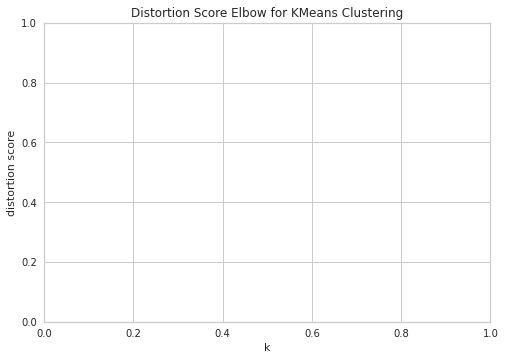

Cluster/Label relationship:
The number of unique labels in the dataset is: 5
Optimal number of clusters is: None


In [5]:
# Scan through the labels and count the number of unique values.
num_labels = y.nunique()
print("INFO: The breakdown of labels in the dataset are:\n{}".format(y.value_counts()))

# Find the optimal number of clusters for the dataset
model = KMeans()
elbowChart = KElbowVisualizer(model, k=(1, 11), timings=False)

elbowChart.fit_transform(X) # Fit the data to the visualiser
elbowChart.show() # Plot the graph and the elbow
plt.show()
optimalClusters = elbowChart.elbow_value_

print("Cluster/Label relationship:")
print(f"The number of unique labels in the dataset is: {num_labels}")
print(f"Optimal number of clusters is: {optimalClusters}")

In [6]:
# instatiate KMeans class and set the number of clusters
model = KMeans(n_clusters=optimalClusters, random_state=10)

# call fit method with data 
km = model.fit_transform(X)

# coordinates of cluster center
centroids = model.cluster_centers_ 

# cluster label for each data point
labels = model.labels_ 

TypeError: '<' not supported between instances of 'int' and 'NoneType'

7. Perform K-Means clustering on the complete dataset and report the purity score.

In [ ]:
# Takes a list that may contain duplicates and returns a list with unique ites.
def uniqueList(list1):
    # insert the list to the set
    list_set = set(list1)
    # convert the set to the list
    unique_list = (list(list_set))
    unique_list.sort()
    return unique_list

# Searches a Series and finds the item that appears with the greatest frequency and returns the count.
def findMaxLabel( data ):
    unique, counts = np.unique(data, return_counts=True)
    # print(np.asarray((unique, counts)).T)
    idx = np.argmax(counts, axis=0)
    # print(f"Index of max: {idx}")

    return unique[idx], counts[idx]

# Given a dataframe of columns "cluster" and "label", it calculates the cluster purity
def calculatePurity(data):
    print("INFO: Calculating clustering purity.")
    print("INFO: Input data:\n{}".format(data))
          
    assert data.shape[1] > 0        # Check we won't have a divide by zero error later

    # Get a list of clusters that has no duplicates so we can use it as a key.
    clusterList = uniqueList(data['cluster'])
    # print(f"Cluster list: {clusterList}")

    # Go through each cluster one by one.
    runningSum = 0
    for c in clusterList:
        # print(f"Counting instances in cluster {c}")
        m1,m2 = findMaxLabel(data[data["cluster"] == c]["label"])
        print("INFO: Maximum frequency in cluster {} is label {}. It has a count of {}.".format(c,m1,m2))
        runningSum = runningSum + m2

    purity = runningSum / data.shape[0]

    return purity

In [ ]:
import sys
np.set_printoptions(threshold=np.inf)
print(y.shape, labels.shape)
d = pd.concat([pd.Series(y),pd.Series(labels)], axis=1)
print()


8. There are several distance metrics for K-Means such as euclidean, squared euclidian, Manhattan, Chebyshev, Minowski.
  * Your job is to compare the purity score of k-means clustering for different distance metrics
  * Select the best distance metric and explain why this distance metric is best for the given dataset.